In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def clean_data(df):
    df['incidents'] = df['incidents'].apply(lambda x: int(x.replace(',', '')))
    df['rate'] = df['rate'].apply(lambda x: float(x.replace(',', '')))
    return df

In [3]:
def set_game_cols(df):
    df.columns = ['lga', 'lga_code', 'reg', 'net', 'dis_score', 'dis_rank_s', 'dis_rank_c', 'dis_rank_m', 'advdis_score', 'advdis_rank_s', 'advdis_rank_c', 'advdis_rank_m', 'pop', 'per_venue', 'per_1000_adults', 'per_adult', 'workforce', 'unemployed', 'urate']
    return df

In [4]:
def filter_lga(df, col='lga'):
    df[col] = df[col].apply(lambda x: x.upper())
    df[col] = df[col].apply(lambda x: 
                            x.replace('CITY', '')
                            .replace('OF', '')
                            .replace('-', ' ')
                            .replace('RURAL', '')
                            .replace("SHIRE", '')
                            .strip())
    return df

In [5]:
def common_cols(*args, col='lga'):
    if len(args) < 2:
        print("Need more than 1")
        return -1
    ddf = args[0]
    ndf = args[1]
    common = set(ddf[col]).intersection(set(ndf[col]))
    for i in range(3,len(args)):
        ndf = args[i]
        common = common.intersection(set(ndf[col]))
    return common

In [6]:
df = pd.read_csv('./gambling-2017.csv')
df = set_game_cols(df)
df = filter_lga(df, col='lga')
crime = pd.read_csv('./crime.csv')
crime.columns =  ['year', 'lga', 'offence', 'sub', 'subsub', 'incidents', 'rate']
crime = clean_data(crime)
crime17 = crime[crime['year']==2017]
crime17 = crime17.groupby('lga').sum().reset_index()

common = common_cols(df, crime17, col='lga')

crime17 = crime17[crime17['lga'].isin(common)]
df = df[df['lga'].isin(common)]

df = df.merge(crime17, on='lga')


df['reg'] = df['reg'].apply(lambda x: 1 if "M" in x else 0)
df['dis_score'] = df['dis_score'].apply(lambda x: float(x))
df['per_venue'] = df['per_venue'].apply(lambda x: np.nan if '-' in x else float(x.replace(',', '')))
df['per_adult'] = df['per_adult'].apply(lambda x: np.nan if '-' in x else float(x))
df['urate'] = df['urate'].apply(lambda x: np.nan if '-' in x else float(x.replace('%', '')))
df = df.dropna()
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 0 to 67
Data columns (total 22 columns):
lga                68 non-null object
lga_code           68 non-null object
reg                68 non-null int64
net                68 non-null object
dis_score          68 non-null float64
dis_rank_s         68 non-null object
dis_rank_c         68 non-null object
dis_rank_m         68 non-null object
advdis_score       68 non-null object
advdis_rank_s      68 non-null object
advdis_rank_c      68 non-null object
advdis_rank_m      68 non-null object
pop                68 non-null object
per_venue          68 non-null float64
per_1000_adults    68 non-null object
per_adult          68 non-null float64
workforce          68 non-null object
unemployed         68 non-null object
urate              68 non-null float64
year               68 non-null int64
incidents          68 non-null int64
rate               68 non-null float64
dtypes: float64(5), int64(3), object(14)
memory usage: 12.2

,lga,lga_code,reg,net,dis_score,dis_rank_s,dis_rank_c,dis_rank_m,advdis_score,advdis_rank_s,...,pop,per_venue,per_1000_adults,per_adult,workforce,unemployed,urate,year,incidents,rate
0,WHITTLESEA,M26,1,"106,994,642.75",988.60,38,-,5,983.36,44,...,"157,370",15737.0,4,679.89,"111,495","8,151",7.31,161360,11637,5529.1
1,NILLUMBIK,M16,1,"8,298,522.61",1098.26,80,-,31,"1,099.03",78,...,"48,614",24307.0,2,170.70,"39,288","1,022",2.60,123037,2023,3207.5
2,ARARAT,C43,0,"4,921,777.36",950.51,11,9,-,938.42,11,...,"8,712",4356.0,10,564.94,"5,616",308,5.48,108918,958,8802.1
3,NORTHERN GRAMPIANS,C14,0,"4,183,804.74",937.59,6,4,-,925.61,5,...,"9,131",4566.0,9,458.19,"5,742",290,5.05,121020,885,7804.9
4,GREATER GEELONG,C21,0,"114,136,381.74",992.90,40,34,-,980.37,39,...,"185,673",7141.0,7,614.72,"121,497","7,578",6.24,163377,17139,7222.1


In [45]:

def norm(df):
    df_min = df.min()
    df_max = df.max()
    return (df-df_min)/(df_max-df_min)

df['ndis_score'] = norm(df['dis_score'])

x = df[['rate', 'ndis_score', 'per_venue', 'reg', 'urate']].as_matrix()



y = df['per_adult'].values
y = y.reshape((len(y), 1))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [47]:
no_epochs = 160000

In [48]:
X = tf.placeholder(tf.float32, shape=[None, x.shape[-1]])
Y = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)

In [49]:
sx = [] # Sampled x values
sy = [] # Sampled y values
real = [] # Real values
predicted = [] # Predicted values

# Leaky ReLu should be used to stop vanishing gradient problem
input_layer = tf.contrib.layers.fully_connected(X, 6, activation_fn=tf.nn.leaky_relu)
# This dropout layer is crucial to stop overfitting, since the data points are very small.
dropout_layer = tf.contrib.layers.dropout(input_layer, keep_prob=keep_prob)
hidden_layer = tf.contrib.layers.fully_connected(dropout_layer, 4, activation_fn=tf.nn.leaky_relu)
output_layer = tf.contrib.layers.fully_connected(dropout_layer, 1, activation_fn=tf.nn.leaky_relu)

loss = tf.reduce_mean(tf.abs(Y - output_layer))

#learning rate is set to a default of 0.001, this is fine, I would probably go lower but
# I want this to finish in a reasonable time.
train = tf.train.AdamOptimizer().minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for i in range(no_epochs):
        if i%100 == 0:
            # We are testing the accuracy so we need fully connected layers here.
            out = sess.run(output_layer, feed_dict={X: X_test, keep_prob: 1.0})
            correct = sess.run(tf.reduce_mean(tf.abs(out - y_test)))
            sx.append(i)
            sy.append(correct)
            print(i, correct)
            
        # Dropout of 0.5 is good to help stop over-fitting. 
        sess.run(train, feed_dict={X: X_train, Y: y_train, keep_prob: 0.5})
    
    # Let us compare how we went against the test set
    out = sess.run(output_layer, feed_dict={X: X_test, keep_prob: 1.0})
    for i in range(len(y_test)):
        real.append(y_test[i][0])
        predicted.append(out[i][0])
        print(out[i], y_test[i], y_test[i]-out[i])


0 748.5920866858442
100 794.5137553604791
200 624.0624335512908
300 533.6546228425399
400 413.3741676627034
500 258.90630510413126
600 218.1376200269616
700 231.2350093410326
800 199.09472916312836
900 198.42485571819805
1000 189.7172665272588
1100 197.13984276813008
1200 184.47193837041442
1300 189.05843049422552
1400 182.76752574091373
1500 191.27124747898264
1600 181.2869793701172
1700 179.98171734353772
1800 182.39591186523438
1900 175.48738100798235
2000 180.68491333007813
2100 183.89193852963655
2200 180.69397705078126
2300 180.1227483600119
2400 168.4454737389606
2500 182.83164043924083
2600 176.4962536621094
2700 179.43842948581863
2800 172.80224811056388
2900 180.8895469599185
3000 187.67089838442595
3100 186.01118503736416
3200 181.46710929538895
3300 177.79861850904385
3400 177.62401019552482
3500 178.82855426290763
3600 176.19126894743547
3700 170.45886830205504
3800 174.06305796747623
3900 174.14161286727244
4000 175.15996189283288
4100 175.10125536047894
4200 182.69852342

33700 153.9642464015795
33800 138.53775403893513
33900 155.25037523352583
34000 142.06967210852582
34100 154.37364576256795
34200 143.8519092858356
34300 138.81536875849187
34400 145.9974210788893
34500 154.81906462296197
34600 144.9904816469939
34700 137.71695089588997
34800 141.41349906589676
34900 140.0727062457541
35000 153.65542252250341
35100 144.52479136591373
35200 142.2501709780486
35300 153.23788720172385
35400 158.7503284222147
35500 142.93471143639607
35600 144.84629537831185
35700 161.3447865627123
35800 151.25283256199052
35900 148.75398824940558
36000 139.66116967242698
36100 142.9806576405401
36200 151.9770488175102
36300 141.46215801736585
36400 160.80248030952788
36500 146.38676434060804
36600 143.04554928986926
36700 136.66306518554688
36800 152.53639791737433
36900 138.4028411334494
37000 141.66540575110395
37100 152.38188134234886
37200 141.49702833092732
37300 148.1328089971128
37400 135.74554387631625
37500 151.43336018437927
37600 140.43378993822182
37700 140.44

66900 147.0392962115744
67000 138.51646736476735
67100 138.12814946713658
67200 144.683378879713
67300 144.60771160623304
67400 142.93274276069974
67500 130.86389568826428
67600 135.13207694675614
67700 147.3640893820058
67800 132.7202315355384
67900 155.5391098951257
68000 155.06722388226055
68100 148.26800135073455
68200 140.2991479757558
68300 136.67702896781591
68400 133.60089314336363
68500 131.02595899498982
68600 130.3881478749151
68700 137.9468014128312
68800 135.71901481296706
68900 144.10099070673405
69000 147.71249628481658
69100 151.73575256347658
69200 146.8884811003312
69300 155.4669338846207
69400 154.2095944744608
69500 165.33560102379843
69600 140.37962853473167
69700 143.74360714456313
69800 129.7915902577276
69900 139.75947589376702
70000 139.4373445063052
70100 134.3621813964844
70200 146.70086290442427
70300 135.55337808360227
70400 140.93706089185633
70500 126.19557123598847
70600 161.5033425505265
70700 149.1372595214844
70800 134.8801967189623
70900 134.18546206

100100 131.19443592900816
100200 132.67974927819296
100300 151.24256959334664
100400 137.9088225787619
100500 138.3476861837636
100600 133.53511397652005
100700 131.57776751974356
100800 140.36603332519533
100900 140.37198149307918
101000 135.26718678350036
101100 135.5884148108441
101200 138.101865207838
101300 139.57567648182746
101400 131.09795686141305
101500 150.51488358207374
101600 134.04767063306727
101700 138.5421959387738
101800 148.57082209048068
101900 135.69951969312586
102000 129.60935974121097
102100 145.66926449983018
102200 127.30105866805368
102300 138.59839151133664
102400 131.11702174974525
102500 151.6150549979832
102600 135.81825824239982
102700 128.98437842327618
102800 146.103678350034
102900 148.0748815917969
103000 137.22002518363624
103100 146.48689145295518
103200 139.2654446278448
103300 148.13933803392496
103400 153.72202164359717
103500 141.17543535315474
103600 139.35221777874492
103700 133.9017873216712
103800 134.84479198953383
103900 128.4767583167035

132000 127.1802349057405
132100 147.3831687197478
132200 138.62013053562333
132300 139.3780810281505
132400 137.80182861328126
132500 130.34261867357338
132600 130.31254123853603
132700 130.90226753566577
132800 128.46131175165593
132900 137.7709258502463
133000 130.71459876019023
133100 147.8762386952276
133200 136.06788477358614
133300 139.06310446034308
133400 132.3485041875425
133500 146.42618071182918
133600 136.5189269488791
133700 143.57794213999875
133800 146.85619793435805
133900 156.21736199420434
134000 142.16509287958561
134100 127.65640402088997
134200 144.95576186470365
134300 130.51341266134514
134400 129.02907075301462
134500 138.0700864576257
134600 151.67601626520573
134700 140.84890987230386
134800 129.03486842943275
134900 165.32387684034265
135000 147.0133819182023
135100 150.16889165463658
135200 143.2675556481403
135300 153.4981241242782
135400 146.6777187446926
135500 137.24632304315983
135600 138.462023607337
135700 139.79704292629077
135800 135.5738300622028
1

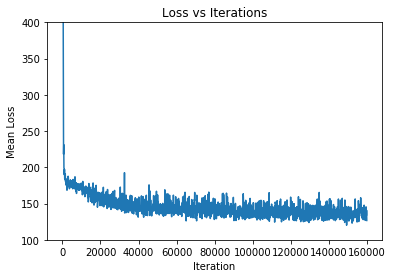

In [57]:
plt.plot(sx, sy)
plt.ylim((100, 400))
plt.xlabel("Iteration")
plt.ylabel('Mean Loss')
plt.title("Loss vs Iterations")
plt.savefig('loss_vs_iter.png', dpi=1080)
plt.show()

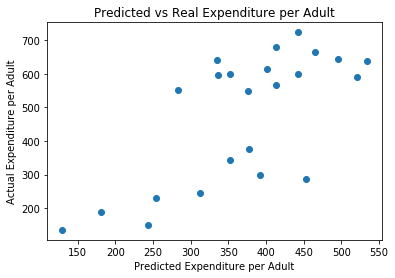

In [51]:
plt.scatter(predicted, real)
plt.xlabel("Predicted Expenditure per Adult")
plt.ylabel("Actual Expenditure per Adult")
plt.title("Predicted vs Real Expenditure per Adult")
plt.savefig('predicted_vs_real_exp.png', dpi=1080)
plt.show()

In [52]:
predicted = np.asarray(predicted)
real = np.asarray(real)
np.mean(np.abs(predicted-real))

144.00686786154043

In [53]:
pearsonr(real, predicted)

(0.7028677157228195, 0.00018385682157472604)

In [ ]:
df.head()